In [ ]:
import os
import torch
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torchmetrics.classification import BinaryJaccardIndex
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from torchmetrics.classification import BinaryF1Score

torch.set_float32_matmul_precision('high')
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype('float32')

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)

        return image, mask

def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_transforms():
    return A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

class SegmentationModel(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.UPerNet(
            encoder_name="tu-convnext_base",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )

        self.dice = smp.losses.DiceLoss(mode='binary')
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.metric = BinaryJaccardIndex()
        self.f1 = BinaryF1Score()
        self.train_losses, self.val_losses = [], []
        self.train_ious, self.val_ious = [], []
        self.train_f1s, self.val_f1s = [], []

    def forward(self, x):
        return self.model(x)

    def loss_fn(self, preds, targets):
        return self.dice(preds, targets) + self.bce(preds, targets)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        iou = self.metric((torch.sigmoid(preds) > 0.5).int(), y.int())
        f1 = self.f1((torch.sigmoid(preds) > 0.5).int(), y.int())

        self.train_losses.append(loss.item())
        self.train_ious.append(iou.item())
        self.train_f1s.append(f1.item())
        self.log('train_loss', loss)
        self.log('train_iou', iou, prog_bar=True)
        self.log('train_f1', f1, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        iou = self.metric((torch.sigmoid(preds) > 0.5).int(), y.int())
        f1 = self.f1((torch.sigmoid(preds) > 0.5).int(), y.int())

        self.val_losses.append(loss.item())
        self.val_ious.append(iou.item())
        self.val_f1s.append(f1.item())
        self.log('val_loss', loss)
        self.log('val_iou', iou, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=3)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_iou',
                'interval': 'epoch',
                'frequency': 1
            }
        }

    def save_progress(self):
        os.makedirs("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics", exist_ok=True)
    
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\train_losses.npy", self.train_losses)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\val_losses.npy", self.val_losses)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\train_ious.npy", self.train_ious)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\val_ious.npy", self.val_ious)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\train_f1s.npy", self.train_f1s)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\val_f1s.npy", self.val_f1s)

        with open("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\metrics_summary.json", "w") as f:
            json.dump({
                "train_losses": self.train_losses,
                "val_losses": self.val_losses,
                "train_ious": self.train_ious,
                "val_ious": self.val_ious,
                "train_f1s": self.train_f1s,
                "val_f1s": self.val_f1s
            }, f)

    def on_train_epoch_end(self):
        self.save_progress()

    def on_validation_epoch_end(self):
        self.save_progress()

    def on_train_end(self):
        os.makedirs("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics", exist_ok=True)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\train_losses.npy", self.train_losses)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\val_losses.npy", self.val_losses)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\train_ious.npy", self.train_ious)
        np.save("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\val_ious.npy", self.val_ious)

        with open("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\metrics_summary.json", "w") as f:
            json.dump({
                "train_losses": self.train_losses,
                "val_losses": self.val_losses,
                "train_ious": self.train_ious,
                "val_ious": self.val_ious
            }, f)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title("Loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.train_ious, label='Train IoU')
        plt.plot(self.val_ious, label='Val IoU')
        plt.title("IoU")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(self.train_f1s, label='Train F1')
        plt.plot(self.val_f1s, label='Val F1')
        plt.title("F1 Score")
        plt.legend()

        plt.tight_layout()
        plt.savefig("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\training_curves.png")
        plt.close()

    @staticmethod
    def load_from_checkpoint_custom(path, lr=1e-3):
        model = SegmentationModel.load_from_checkpoint(path, lr=lr)
        return model

def main_pnoa_transfer():
    checkpoint_path = "G:\\jorge\\models\\UPerNet-Convnext_base\\checkpoints\\best_model_epoch=30_val_iou=0.7955.ckpt"
    new_lr = 1e-4 

    base_path = "G:\\jorge\\Datasets\\PNOA"
    train_ds = SegmentationDataset(
        image_dir=os.path.join(base_path, 'train', 'images'),
        mask_dir=os.path.join(base_path, 'train', 'masks'),
        transforms=get_train_transforms()
    )
    val_ds = SegmentationDataset(
        image_dir=os.path.join(base_path, 'val', 'images'),
        mask_dir=os.path.join(base_path, 'val', 'masks'),
        transforms=get_val_transforms()
    )
    test_ds = SegmentationDataset(
        image_dir=os.path.join(base_path, 'test', 'images'),
        mask_dir=os.path.join(base_path, 'test', 'masks'),
        transforms=get_val_transforms()
    )

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)

    model = SegmentationModel.load_from_checkpoint_custom(checkpoint_path, lr=new_lr)

    callbacks = [
        EarlyStopping(monitor="val_iou", patience=5, mode="max"),
        ModelCheckpoint(
            dirpath="G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\checkpoints",
            filename="best_model_{epoch:02d}_{val_iou:.4f}",
            monitor="val_iou",
            save_top_k=1,
            mode="max",
        ),
        LearningRateMonitor(logging_interval='epoch')
    ]

    trainer = pl.Trainer(
        max_epochs=100,
        accelerator="gpu",
        devices=1,
        callbacks=callbacks,
        log_every_n_steps=10
    )

    trainer.fit(model, train_loader, val_loader)

    results = trainer.validate(model, dataloaders=test_loader, verbose=True)
    print("Resultados en TEST:", results)

if __name__ == "__main__":
    main_pnoa_transfer()



INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/convnext_base.fb_in22k_ft_in1k)
INFO:timm.models._hub:[timm/convnext_base.fb_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightn

Sanity Checking: |                                                                               | 0/? [00:00<…

G:\jorge\envs\nuevo-entorno\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
G:\jorge\envs\nuevo-entorno\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                    | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.8541094064712524     │
│          val_iou          │    0.7501071691513062     │
│         val_loss          │    0.3335418701171875     │
└───────────────────────────┴───────────────────────────┘

Resultados en TEST: [{'val_loss': 0.3335418701171875, 'val_iou': 0.7501071691513062, 'val_f1': 0.8541094064712524}]


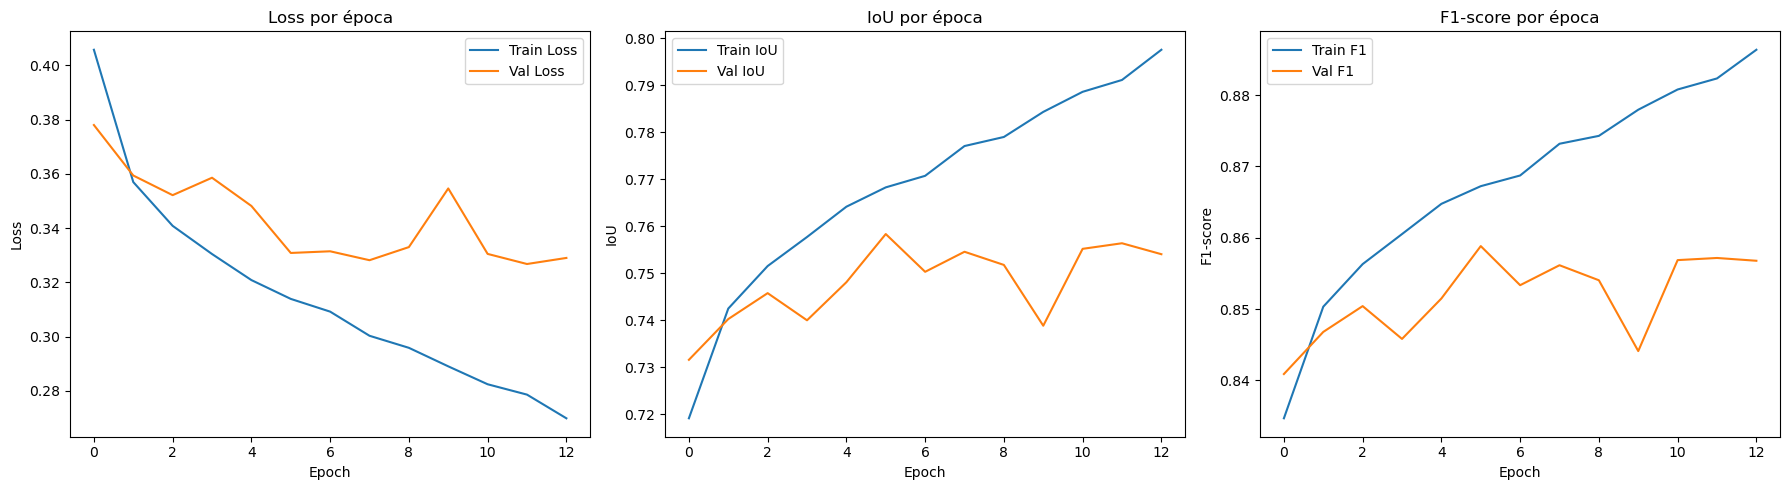

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = "G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\"

train_losses = np.load(os.path.join(base_path, "train_losses.npy"))
val_losses = np.load(os.path.join(base_path, "val_losses.npy"))
train_ious = np.load(os.path.join(base_path, "train_ious.npy"))
val_ious = np.load(os.path.join(base_path, "val_ious.npy"))
train_f1s = np.load(os.path.join(base_path, "train_f1s.npy"))
val_f1s = np.load(os.path.join(base_path, "val_f1s.npy"))

num_epochs = 13

steps_per_epoch_train = len(train_losses) // num_epochs
steps_per_epoch_val = len(val_losses) // num_epochs

def average_per_epoch(array, steps_per_epoch):
    return np.mean(array[:steps_per_epoch*num_epochs].reshape(num_epochs, steps_per_epoch), axis=1)

train_loss_avg = average_per_epoch(train_losses, steps_per_epoch_train)
val_loss_avg = average_per_epoch(val_losses, steps_per_epoch_val)
train_iou_avg = average_per_epoch(train_ious, steps_per_epoch_train)
val_iou_avg = average_per_epoch(val_ious, steps_per_epoch_val)
train_f1_avg = average_per_epoch(train_f1s, steps_per_epoch_train)
val_f1_avg = average_per_epoch(val_f1s, steps_per_epoch_val)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(train_loss_avg, label="Train Loss")
plt.plot(val_loss_avg, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_iou_avg, label="Train IoU")
plt.plot(val_iou_avg, label="Val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("IoU por época")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1_avg, label="Train F1")
plt.plot(val_f1_avg, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("F1-score por época")
plt.legend()

plt.tight_layout()
plt.savefig("G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\metrics\\training_curves_combined_with_f1.png")
plt.show()

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/convnext_base.fb_in22k_ft_in1k)
INFO:timm.models._hub:[timm/convnext_base.fb_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


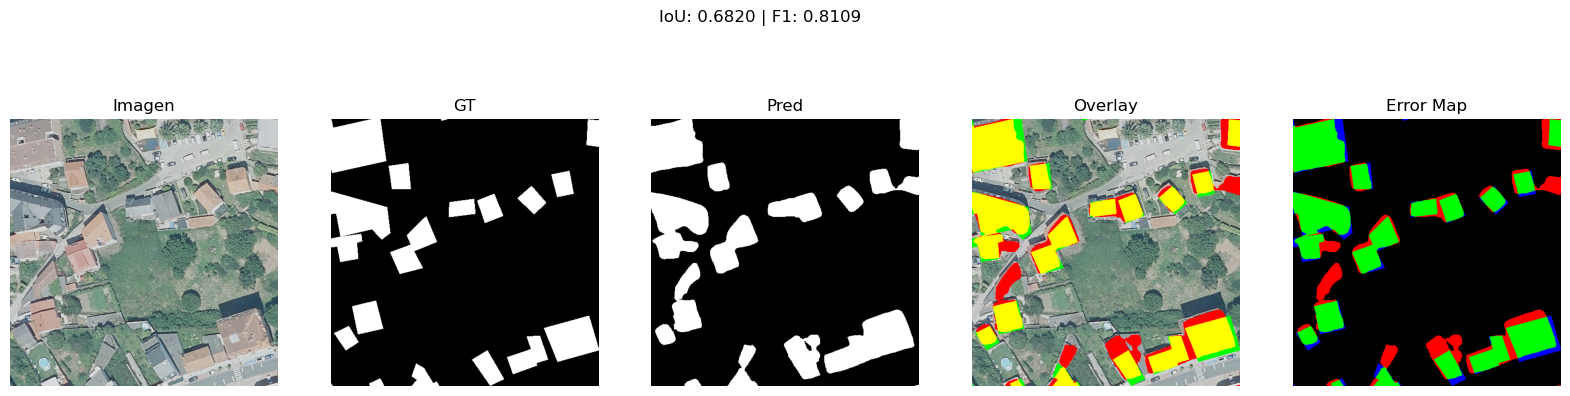

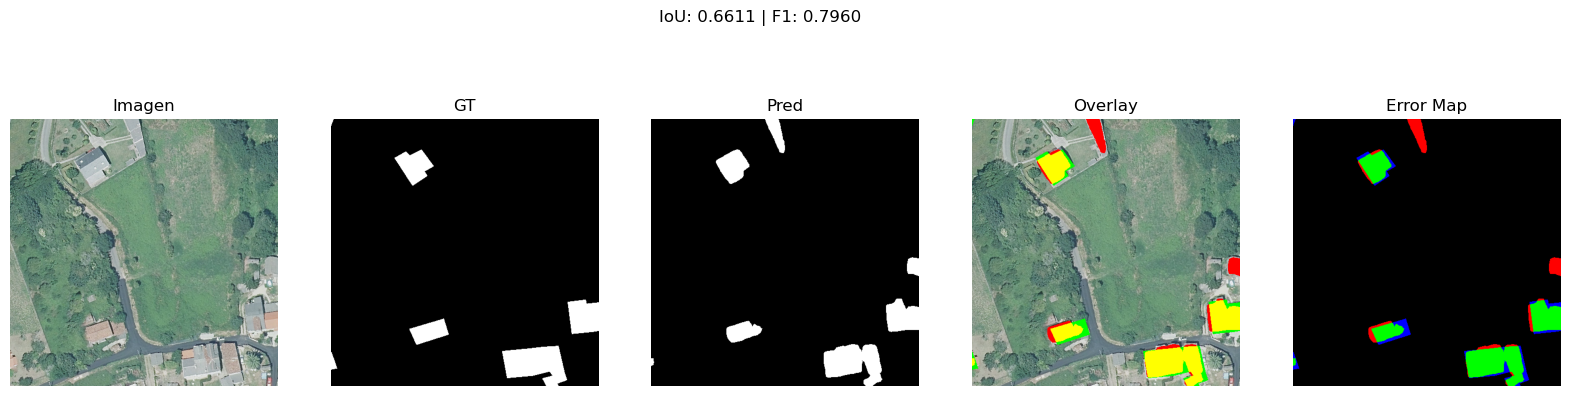

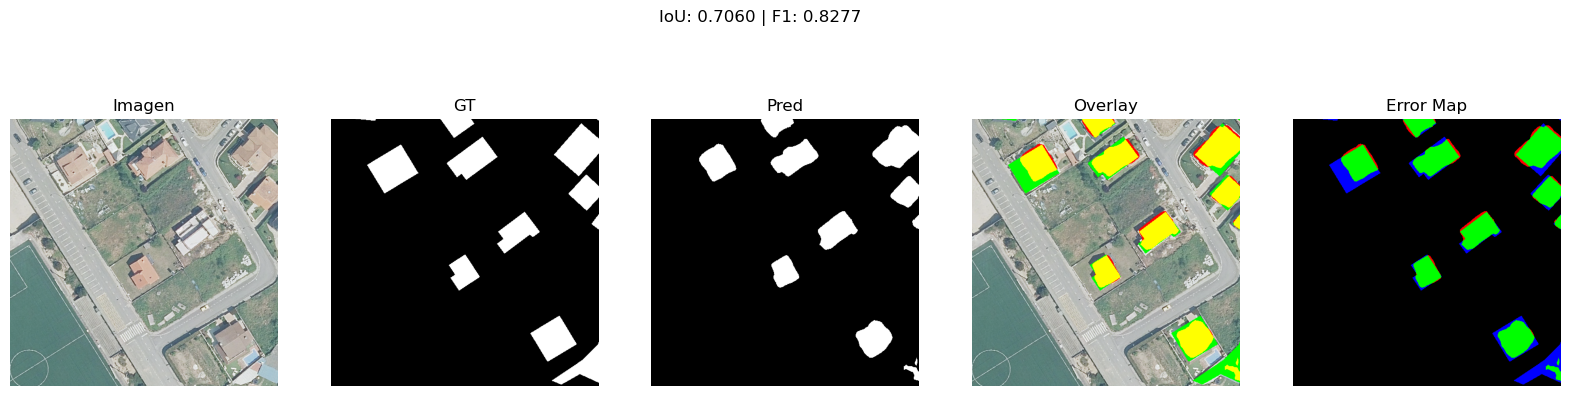

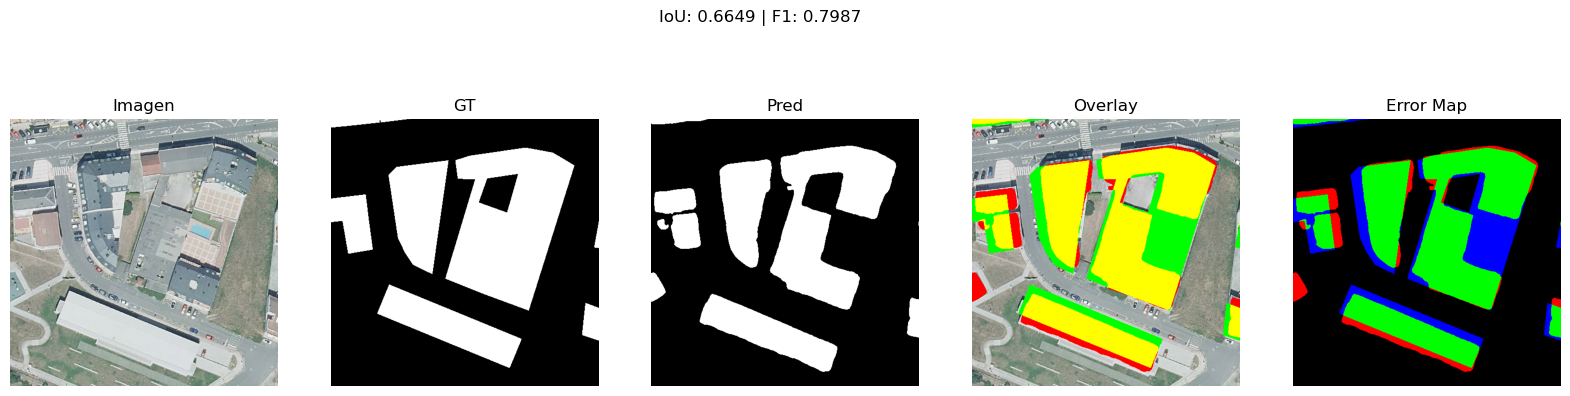

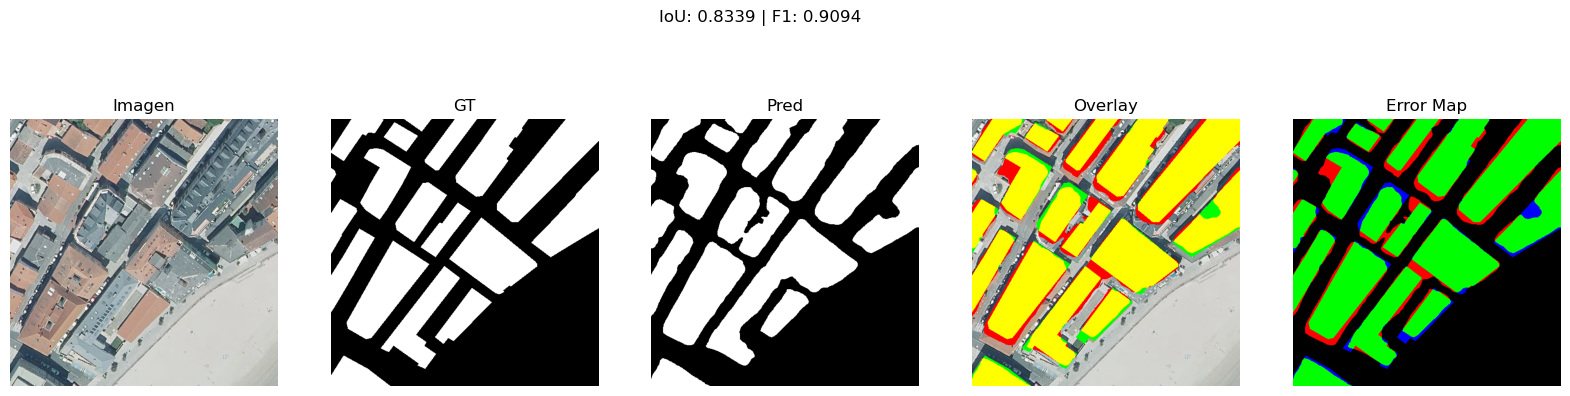

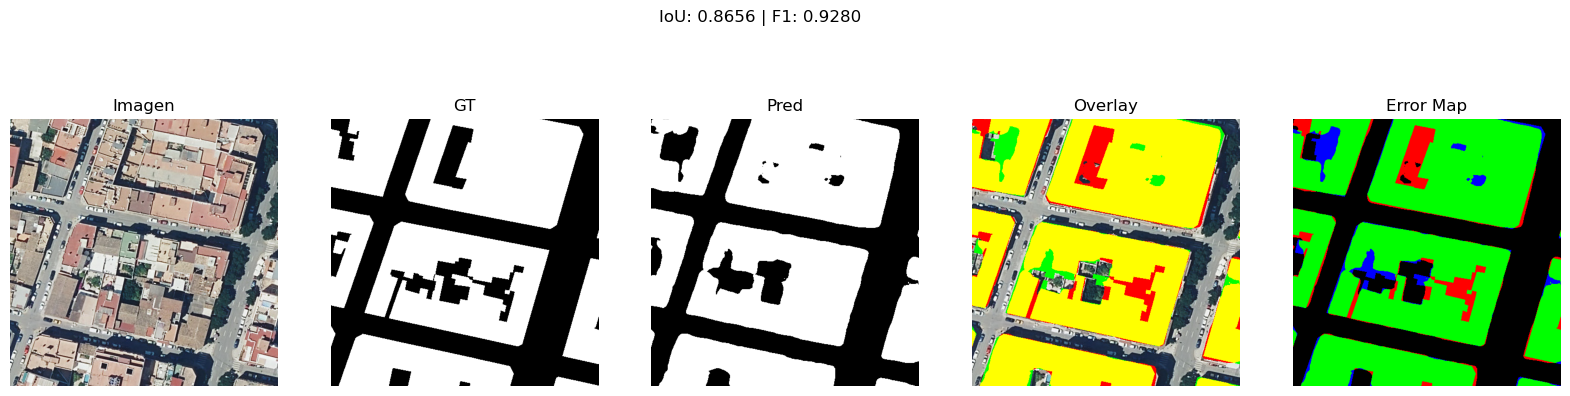

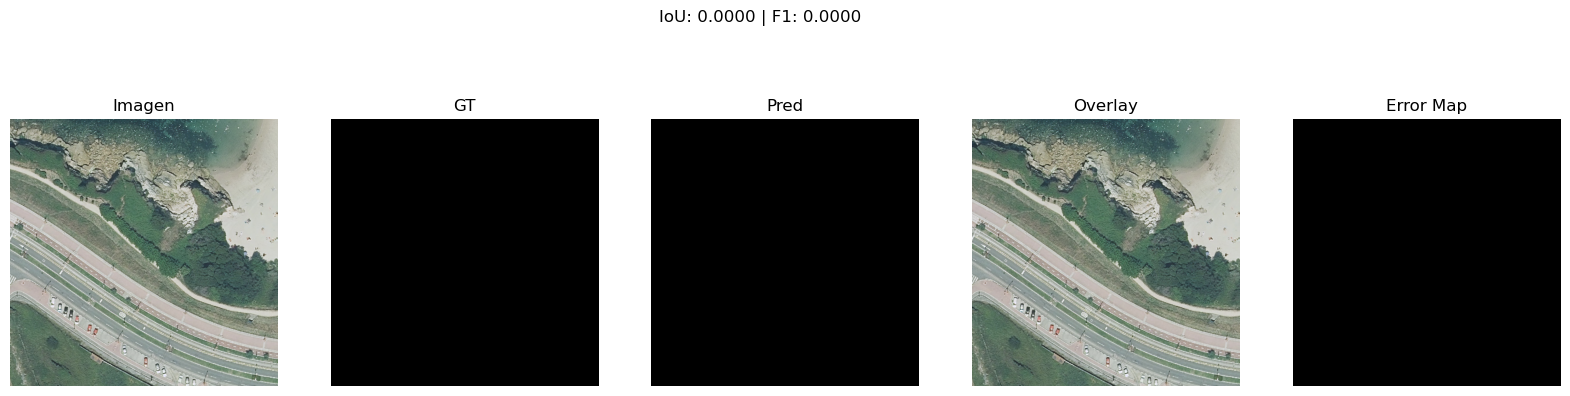

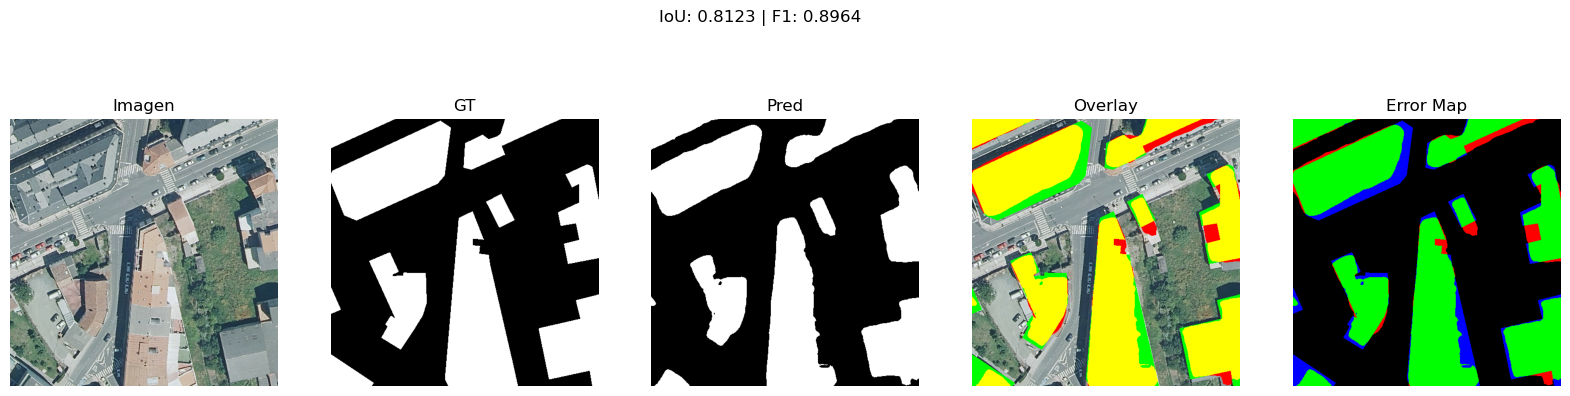

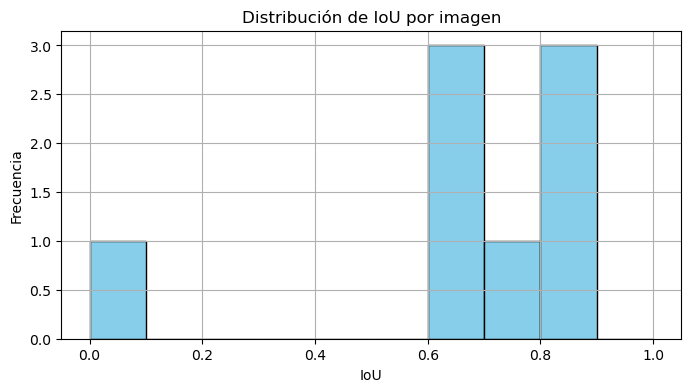

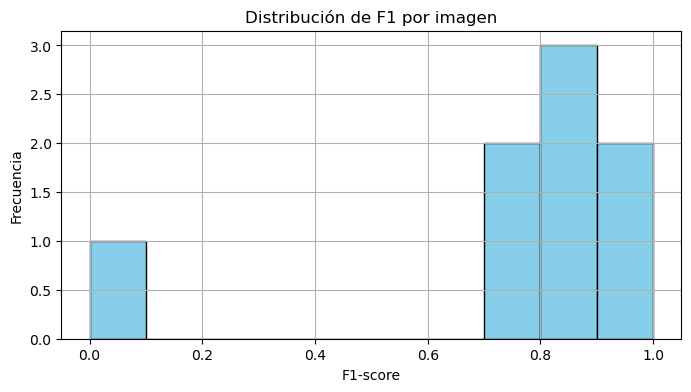

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

from torchvision.utils import make_grid

checkpoint_path = "G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\checkpoints\\best_model_epoch=07_val_iou=0.7561.ckpt"

def visualize_predictions(model, dataset, device='cuda', num_samples=5, save_dir=None, csv_path=None):
    model.eval()
    model.to(device)

    indices = np.random.choice(len(dataset), num_samples, replace=False)
    ious = []
    f1s = []

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for i, idx in enumerate(indices):
        image, gt_mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device) 
        with torch.no_grad():
            pred = model(image_tensor)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred_mask = (pred > 0.5).astype(np.uint8)

        gt_mask_np = gt_mask.squeeze().cpu().numpy().astype(np.uint8)
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) 
        image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)

        intersection = np.logical_and(pred_mask, gt_mask_np).sum()
        union = np.logical_or(pred_mask, gt_mask_np).sum()
        iou = intersection / union if union != 0 else 0.0

        precision = intersection / (pred_mask.sum() + 1e-8)
        recall = intersection / (gt_mask_np.sum() + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        ious.append(iou)
        f1s.append(f1)

        overlay = image_np.copy()
        overlay[gt_mask_np == 1] = [0, 255, 0] 
        overlay[pred_mask == 1] = [255, 0, 0]  
        overlay[(gt_mask_np == 1) & (pred_mask == 1)] = [255, 255, 0] 

        error_map = np.zeros_like(image_np)
        error_map[(gt_mask_np == 1) & (pred_mask == 0)] = [0, 0, 255]   
        error_map[(gt_mask_np == 0) & (pred_mask == 1)] = [255, 0, 0]      
        error_map[(gt_mask_np == 1) & (pred_mask == 1)] = [0, 255, 0]     

        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        titles = ["Imagen", "GT", "Pred", "Overlay", "Error Map"]
        images = [image_np,
                  (gt_mask_np * 255).astype(np.uint8),
                  (pred_mask * 255).astype(np.uint8),
                  overlay,
                  error_map]

        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img if img.ndim == 3 else img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')

        fig.suptitle(f"IoU: {iou:.4f} | F1: {f1:.4f}")
        if save_dir:
            plt.savefig(os.path.join(save_dir, f"sample_{i}_iou_{iou:.4f}_f1_{f1:.4f}.png"))
        plt.show()

    if csv_path:
        df = pd.DataFrame({
            "SampleIndex": indices,
            "IoU": ious,
            "F1": f1s
        })
        df.to_csv(csv_path, index=False)

    return ious, f1s


def plot_histogram(values, title, xlabel, save_path=None):
    plt.figure(figsize=(8, 4))
    plt.hist(values, bins=10, range=(0, 1), color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frecuencia")
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

model = SegmentationModel.load_from_checkpoint(checkpoint_path)

test_dataset = SegmentationDataset(
    image_dir='G:\\jorge\\Datasets\\PNOA\\test\\images',
    mask_dir='G:\\jorge\\Datasets\\PNOA\\test\\masks',
    transforms=get_val_transforms()
)

ious, f1s = visualize_predictions(
    model,
    test_dataset,
    num_samples=8,
    save_dir="G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\visualizations",
    csv_path="G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\visualizations\\metrics_per_sample.csv"
)

plot_histogram(ious, "Distribución de IoU por imagen", "IoU",
               save_path="G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\visualizations\\iou_hist.png")

plot_histogram(f1s, "Distribución de F1 por imagen", "F1-score",
               save_path="G:\\jorge\\models\\UPerNet-Convnext_base_PNOA\\visualizations\\f1_hist.png")

In [4]:
print(f"Media IoU (Test PNOA): {np.mean(ious):.4f} ± {np.std(ious):.4f}")
print(f"Media F1 (Test PNOA): {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")


Media IoU (Test PNOA): 0.6532 ± 0.2583
Media F1 (Test PNOA): 0.7459 ± 0.2862
